
--- Running Simulations for: B:0.0, S:0.0 Environment ---



--- Running Simulations for: B:0.0, S:0.25 Environment ---



--- Running Simulations for: B:0.0, S:0.5 Environment ---



--- Running Simulations for: B:0.25, S:0.0 Environment ---



--- Running Simulations for: B:0.25, S:0.25 Environment ---



--- Running Simulations for: B:0.25, S:0.5 Environment ---



--- Running Simulations for: B:0.5, S:0.0 Environment ---



--- Running Simulations for: B:0.5, S:0.25 Environment ---



--- Running Simulations for: B:0.5, S:0.5 Environment ---



--- Training Summary Statistics (Final Asset Value) ---
                                 mean        std
Environment    Algorithm                        
B:0.0, S:0.0   MonteCarlo     16592.0       61.0
               QLearning      16429.0       61.0
               Random         16442.0       78.0
               SARSA          16553.0       52.0
               SARSA(λ)       16453.0       54.0
B:0.0, S:0.25  MonteCarlo     16321.0      136.0
               QLearning      16277.0      107.0
               Random         16223.0      112.0
               SARSA          16285.0      104.0
               SARSA(λ)       16270.0      110.0
B:0.0, S:0.5   MonteCarlo     16061.0      129.0
               QLearning      16004.0      121.0
               Random         16011.0      124.0
               SARSA          16040.0      119.0
               SARSA(λ)       16008.0      117.0
B:0.25, S:0.0  MonteCarlo    468196.0   105908.0
               QLearning     473281.0   107167.0
            

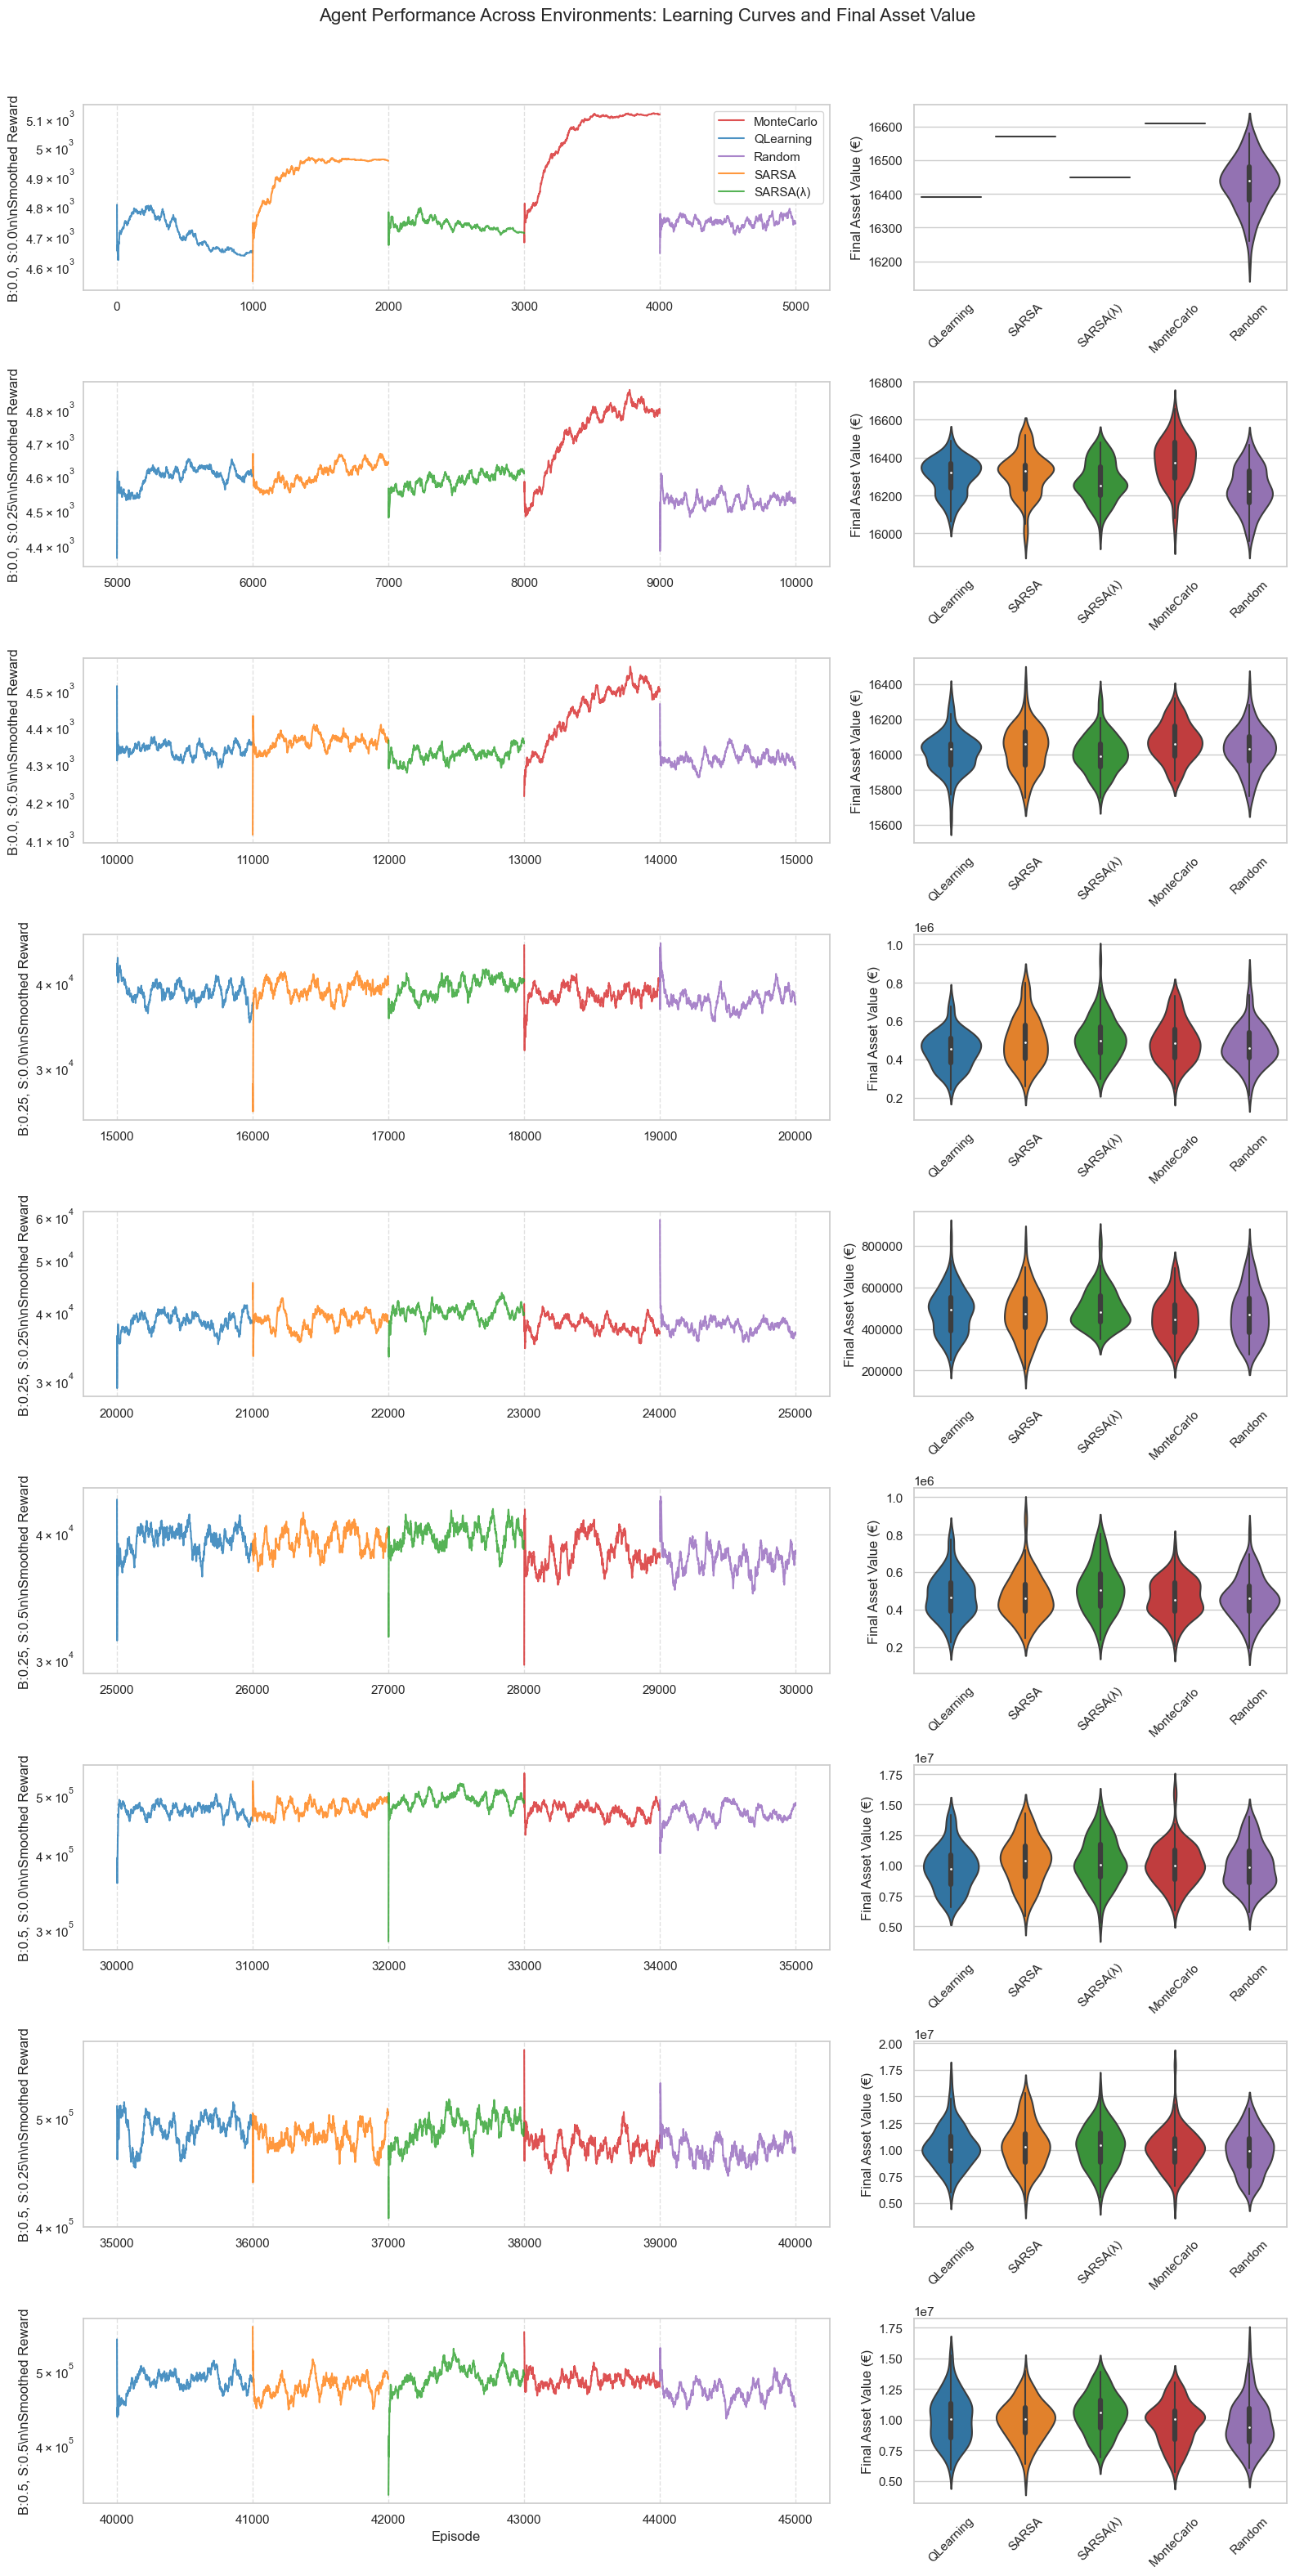

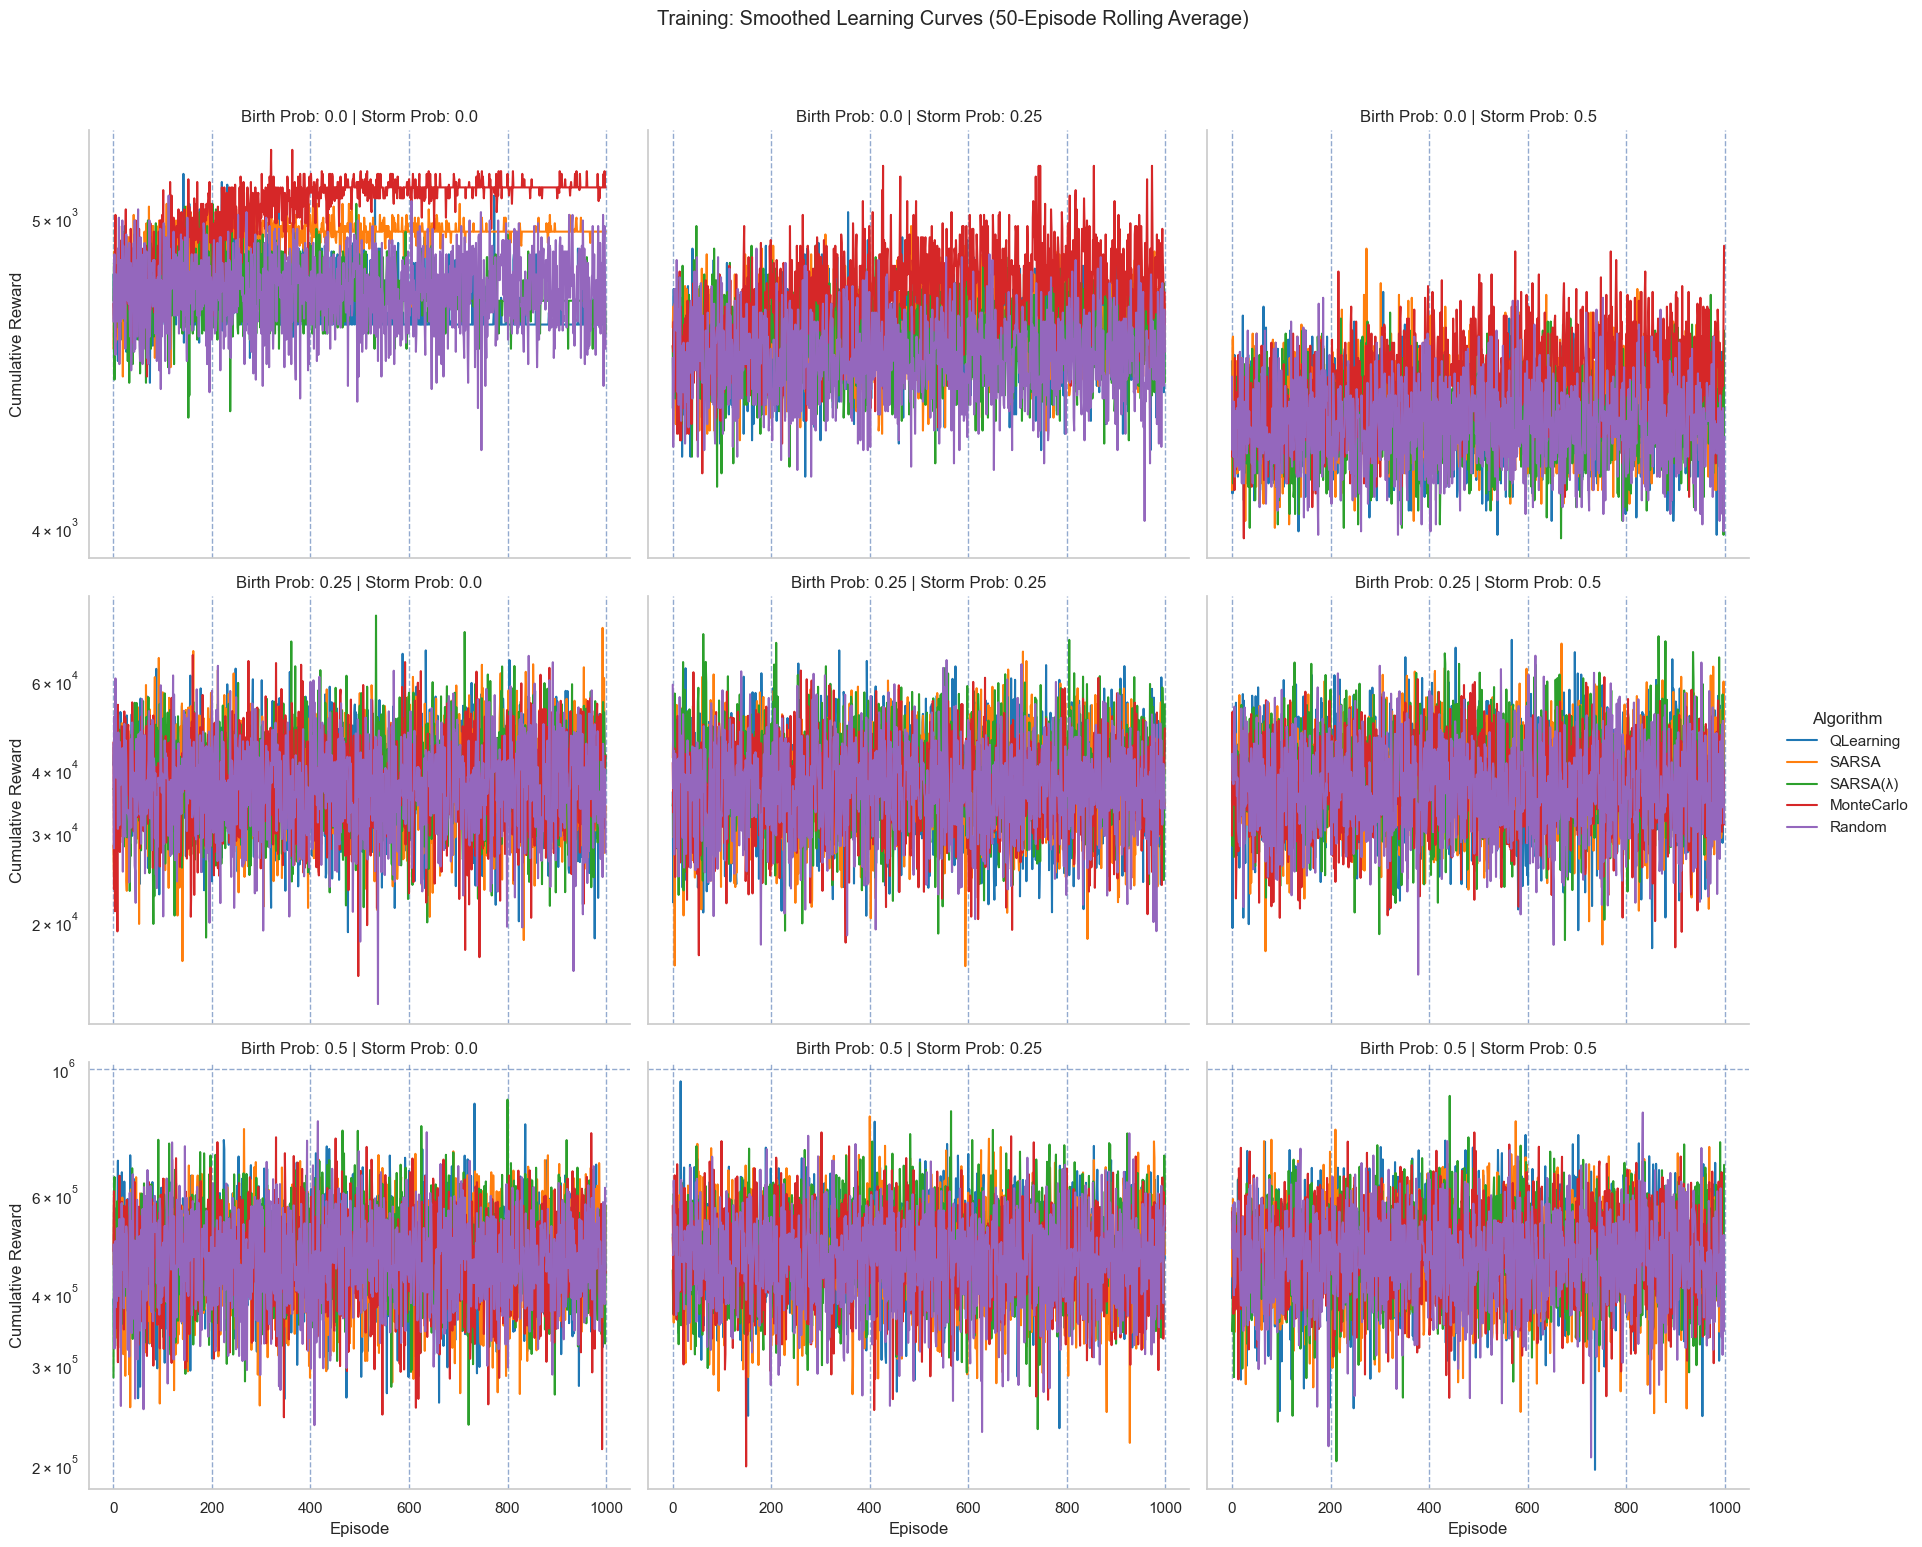

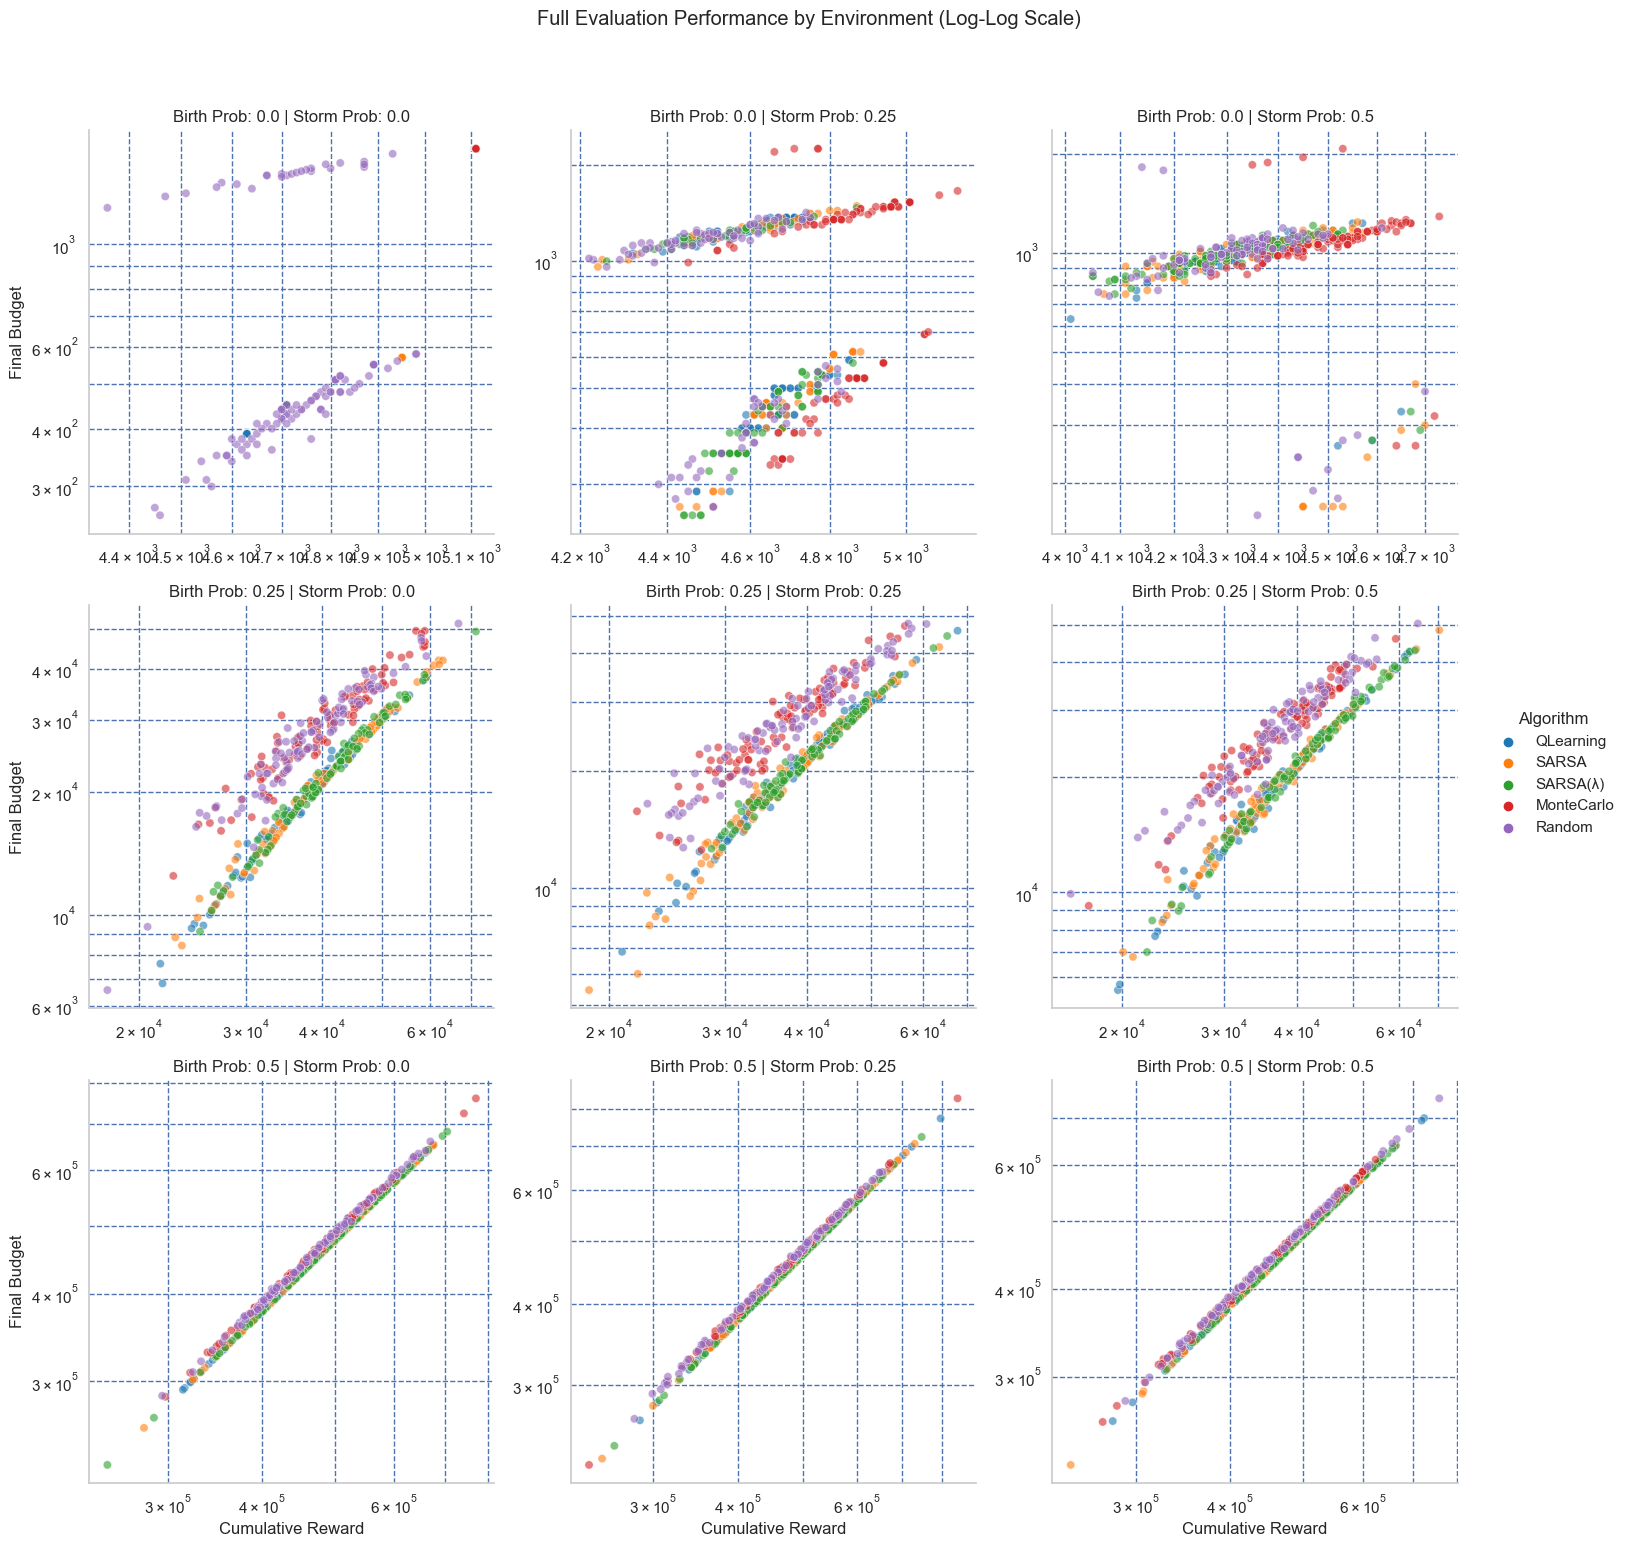

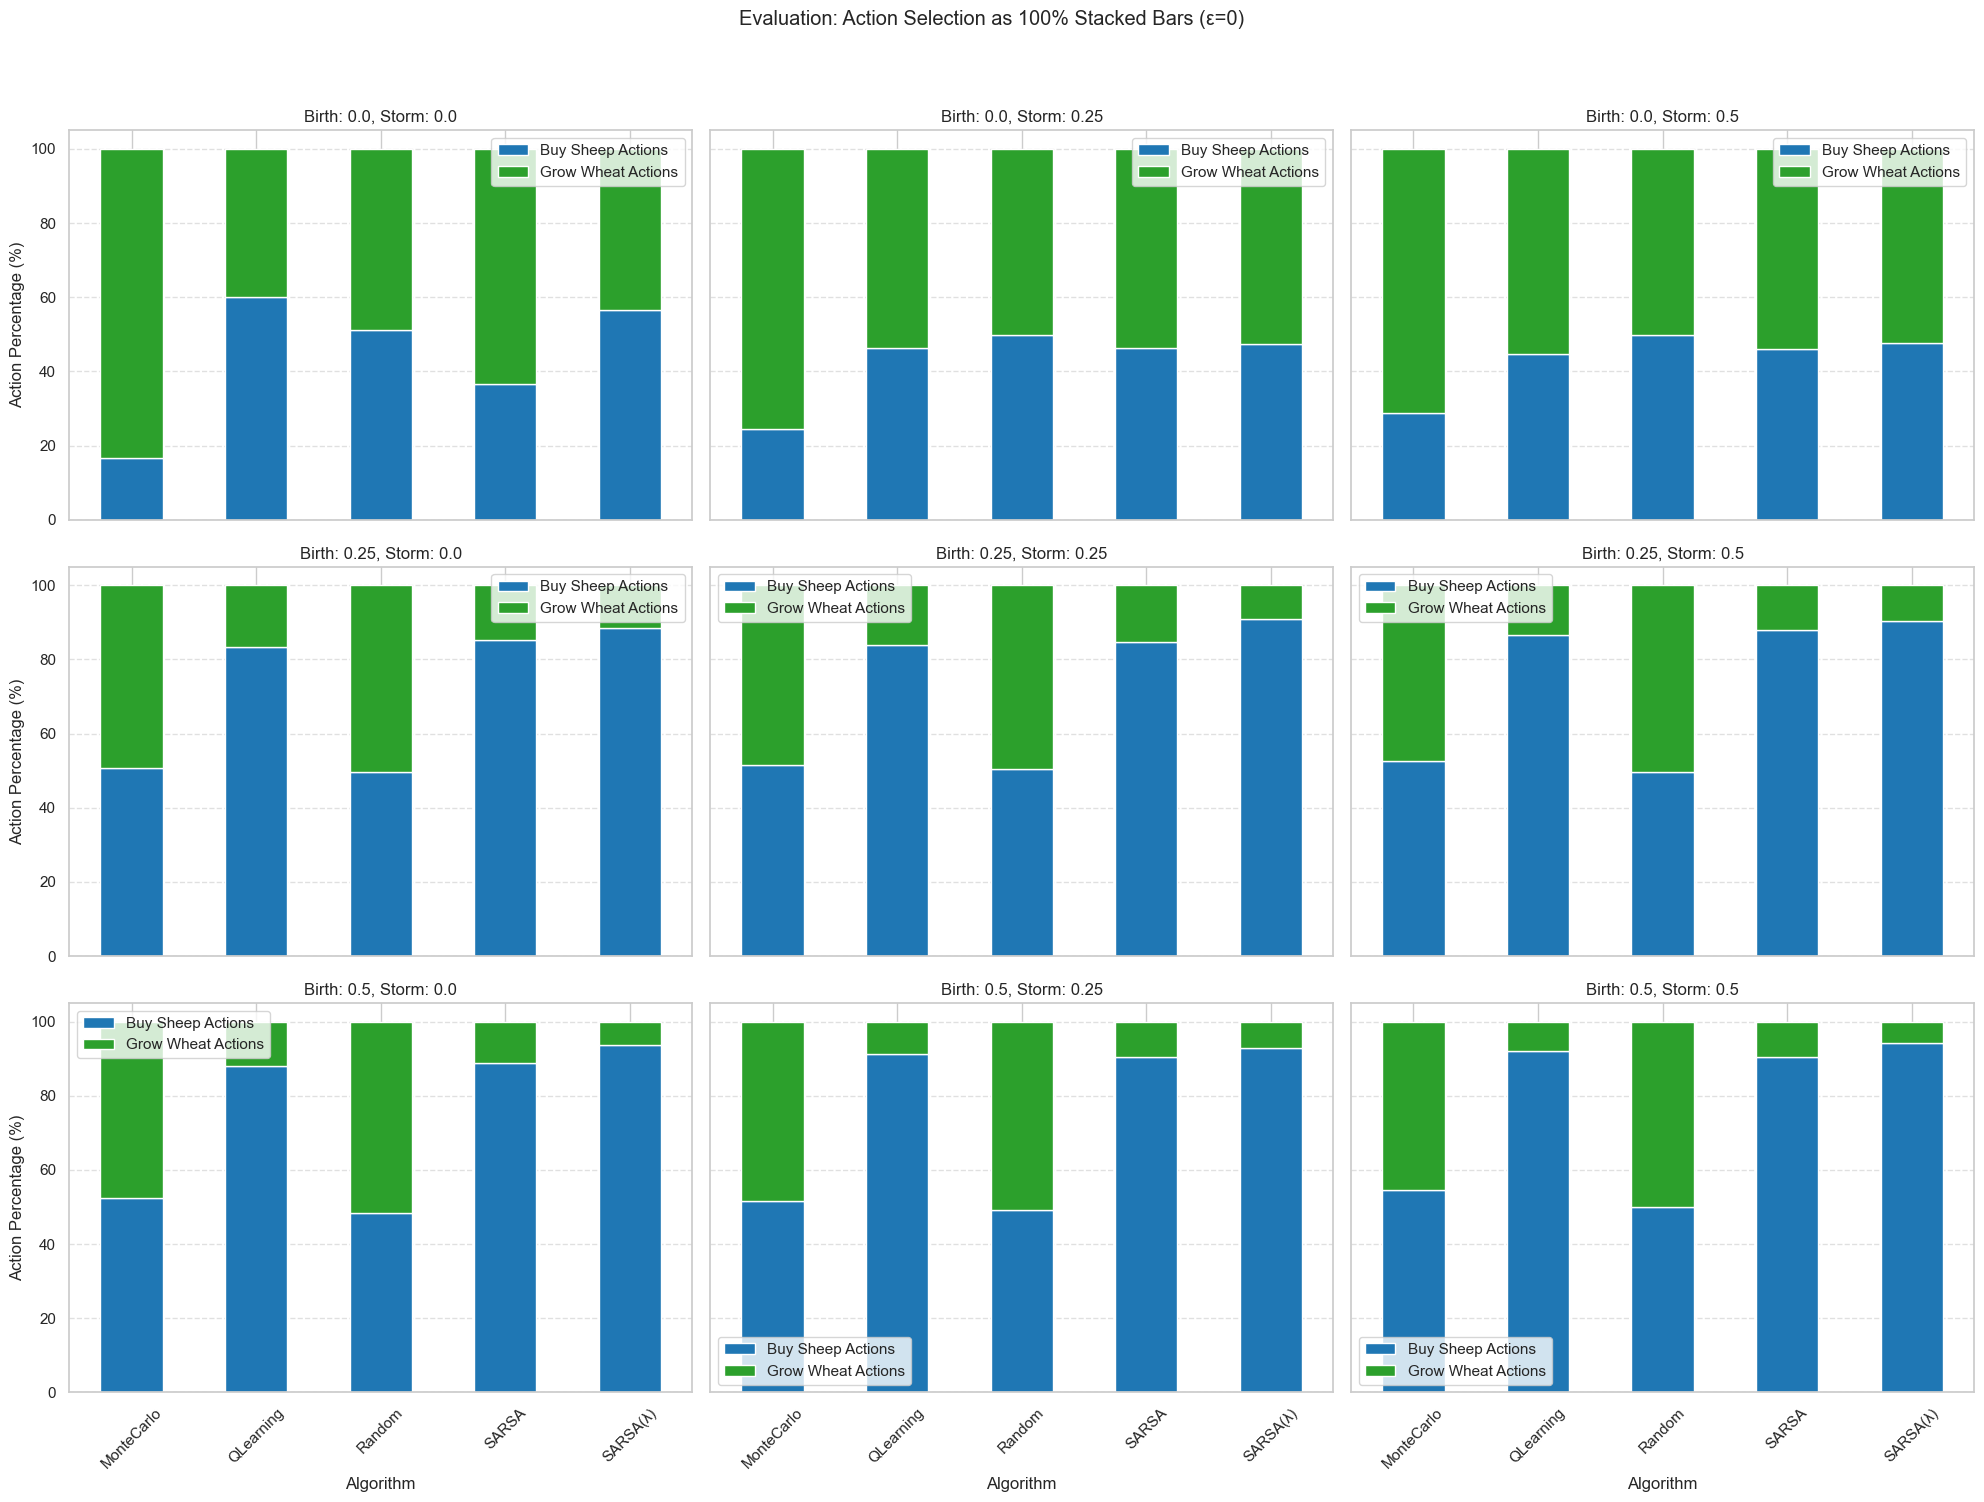

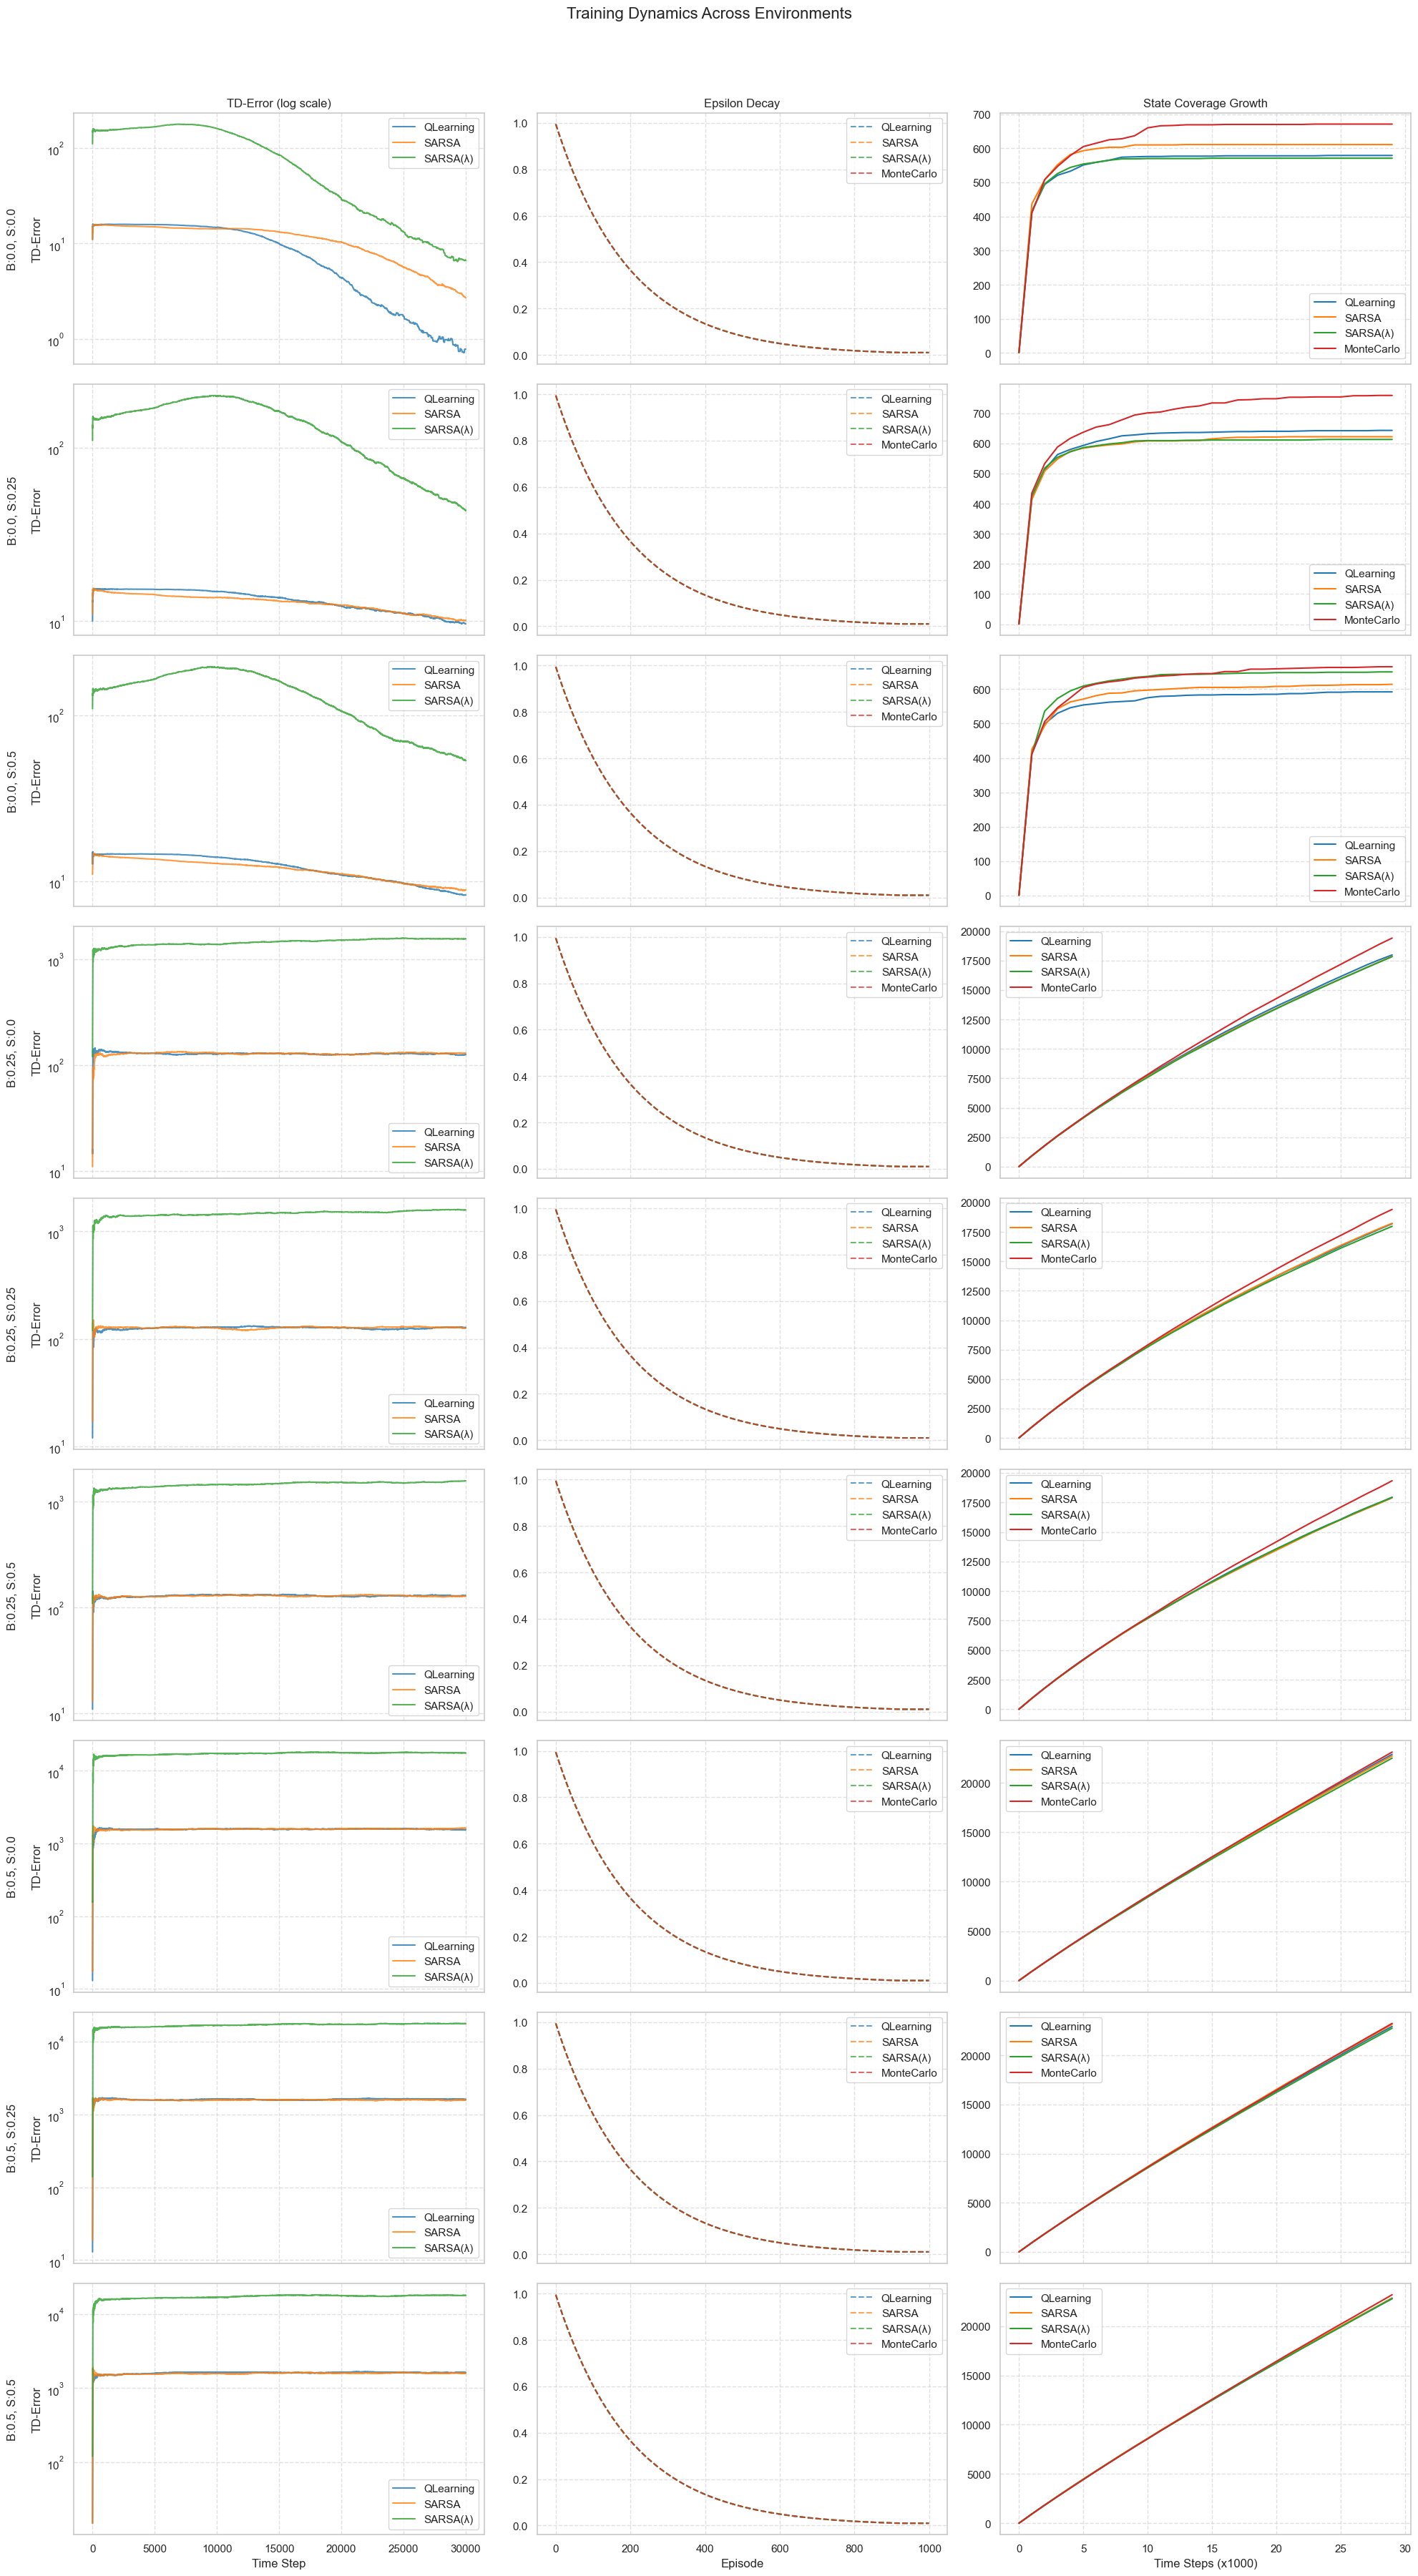


Displaying Policy Functions Grid...


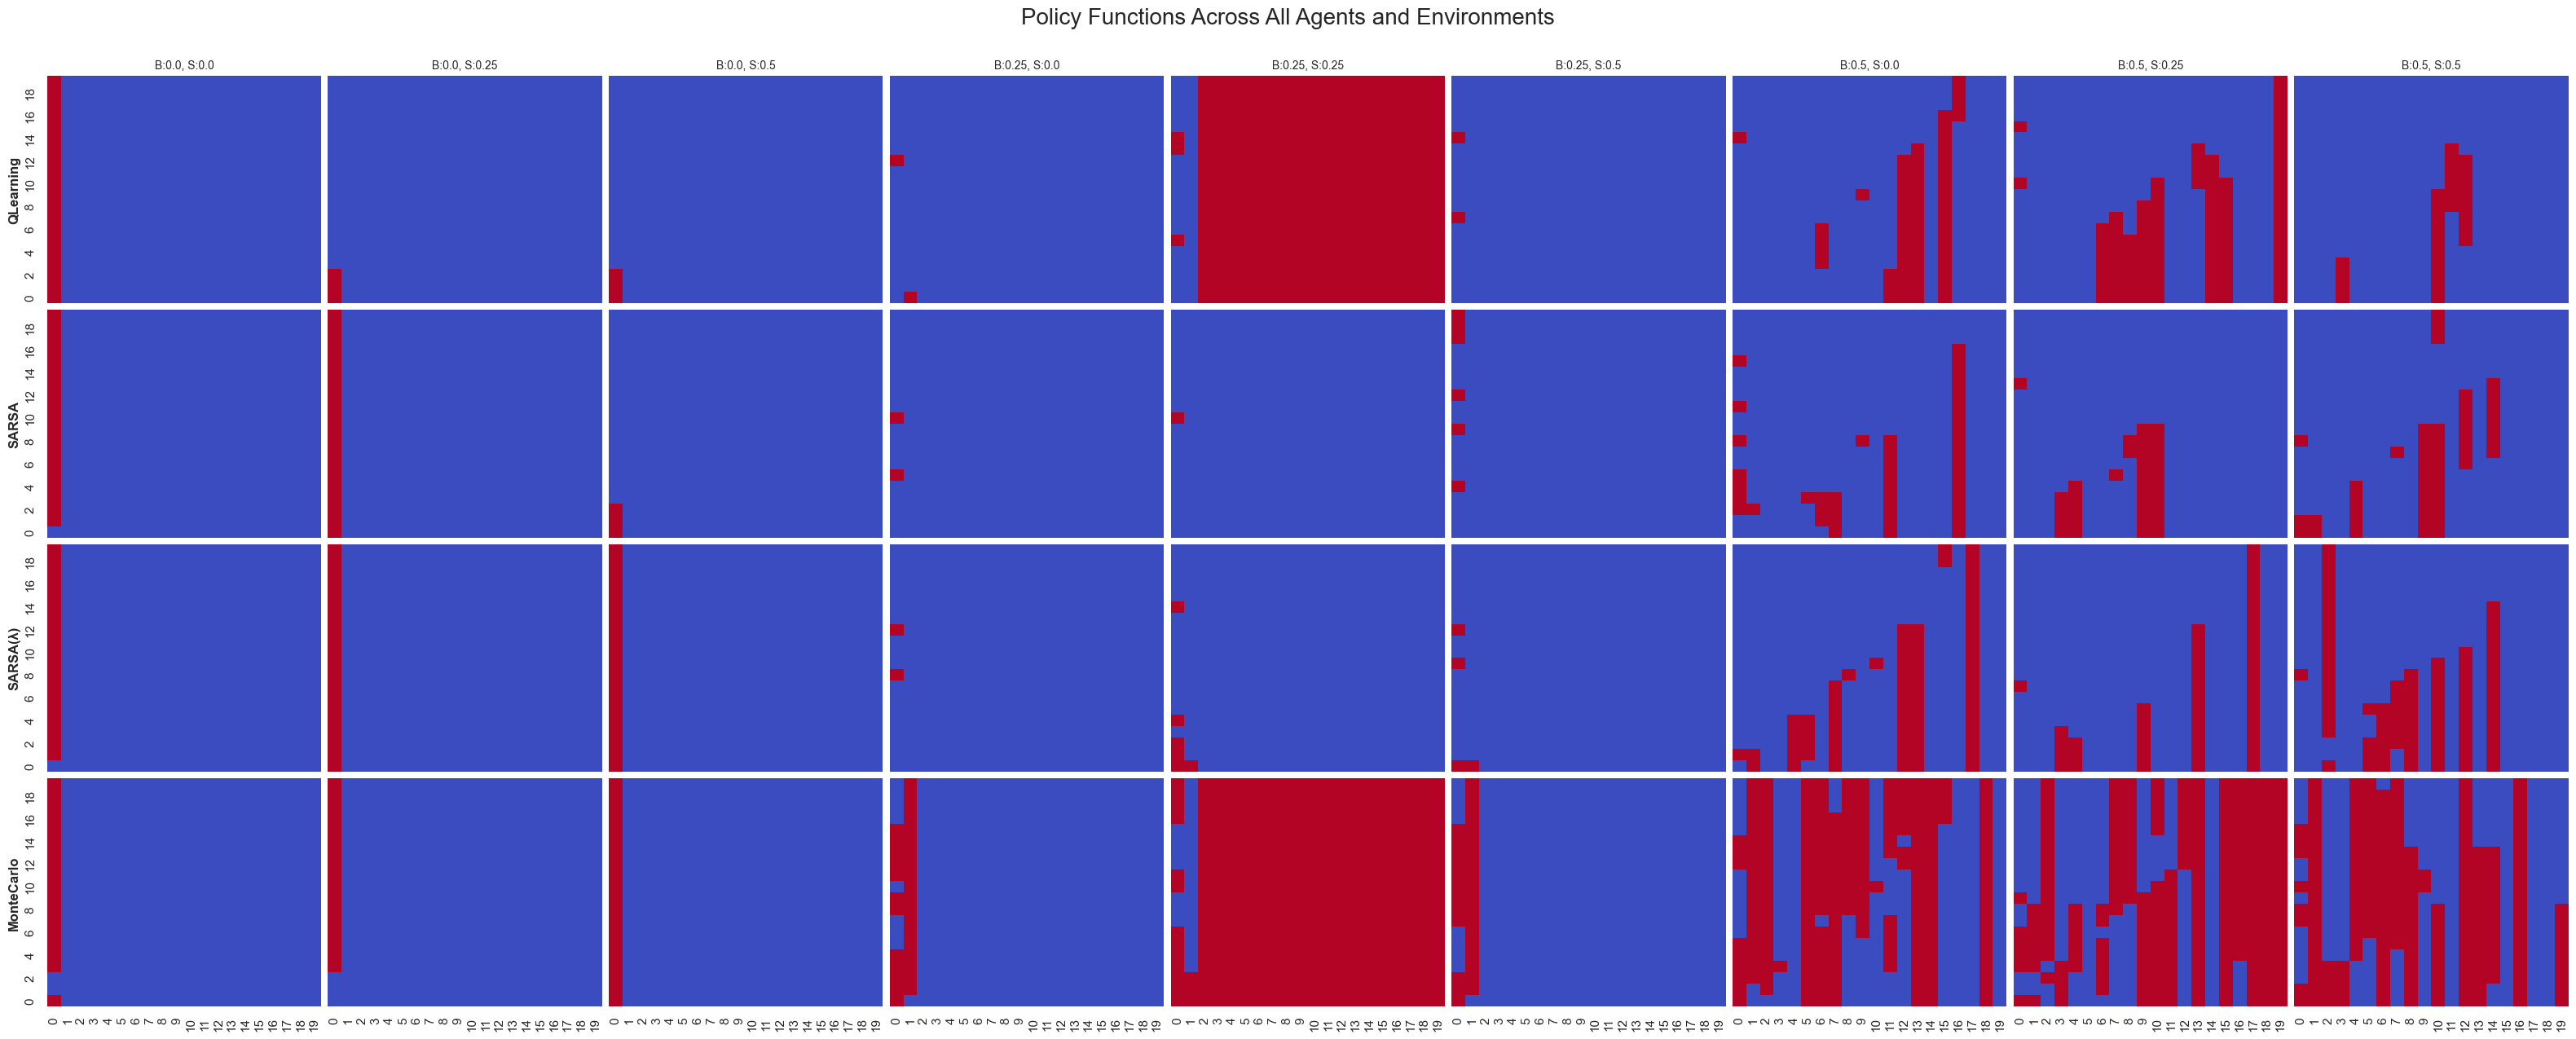

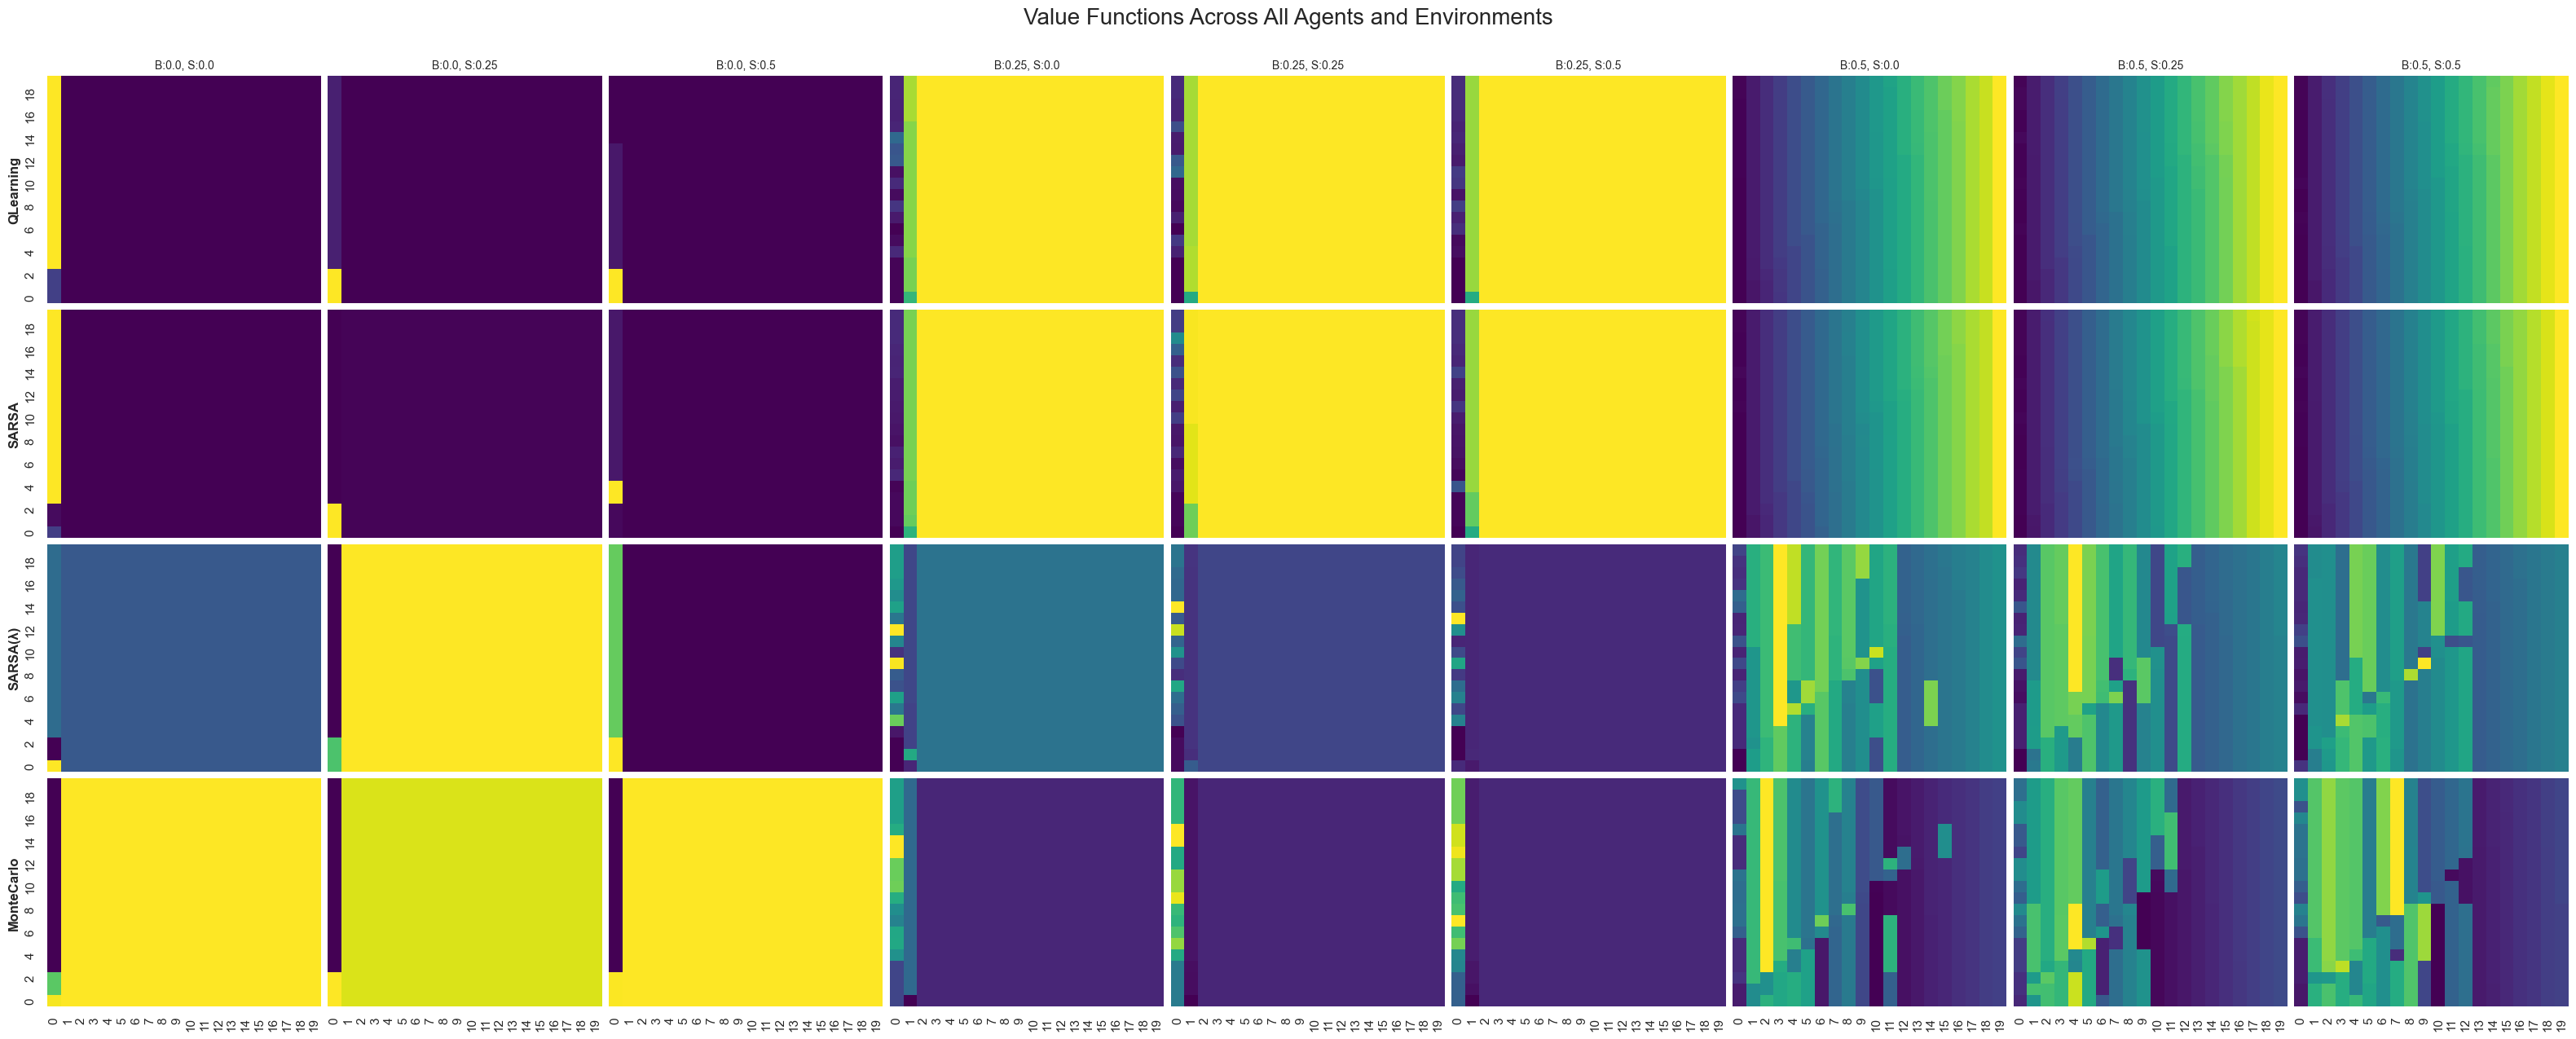

Saved: plots\plot6_policy_functions_grid.png

Displaying Value Functions Grid...
Saved: plots\plot7_value_functions_grid.png

Done. All plots saved to 'plots/' directory.


In [1]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import itertools
from dataclasses import dataclass, field
from typing import List, Tuple, Dict, Any
import os

# --- Configuration & Constants ---

@dataclass
class EnvConstants:
    """Constants defining the economics of the farm environment."""
    MAX_YEARS: int = 30
    INITIAL_BUDGET: float = 2000.0
    INITIAL_SHEEP: int = 10
    SHEEP_COST: float = 1000.0
    WHEAT_COST: float = 20.0
    WOOL_REWARD_PER_SHEEP: float = 10.0
    WHEAT_REWARD: float = 50.0

@dataclass
class AgentConfig:
    """Hyperparameters for RL agents."""
    learning_rate: float = 0.1
    discount_factor: float = 0.95
    epsilon: float = 1.0
    epsilon_decay: float = 0.995
    epsilon_min: float = 0.01
    lambda_val: float = 0.9  # For Sarsa(λ)

# --- Environment Definition ---
class FarmEnv(gym.Env):
    """
    Custom environment for the farm management simulation, aligned with project specifications.
    """
    def __init__(self, birth_prob: float = 0.5, storm_prob: float = 0.25, constants: EnvConstants = EnvConstants()):
        super(FarmEnv, self).__init__()
        self.birth_prob = birth_prob
        self.storm_prob = storm_prob
        self.c = constants
        self.action_space = spaces.Discrete(2) # 0: Buy Sheep, 1: Grow Wheat
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(2,), dtype=np.float32)
        self.reset()

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, dict]:
        if action == 0:
            if self.budget >= self.c.SHEEP_COST:
                self.budget -= self.c.SHEEP_COST
                self.num_sheep += 1
        elif action == 1:
            self.budget -= self.c.WHEAT_COST

        new_sheep = sum(1 for _ in range(self.num_sheep // 2) if random.random() < self.birth_prob)
        self.num_sheep += new_sheep
        storm_happened = random.random() < self.storm_prob
        wool_income = self.num_sheep * self.c.WOOL_REWARD_PER_SHEEP
        wheat_income = self.c.WHEAT_REWARD if action == 1 and not storm_happened else 0
        total_income = wool_income + wheat_income
        self.budget += total_income
        reward = total_income
        self.state = np.array([self.budget, self.num_sheep])
        self.current_year += 1
        done = self.budget < self.c.WHEAT_COST or self.current_year >= self.c.MAX_YEARS
        return self.state, reward, done, {}

    def reset(self) -> np.ndarray:
        self.budget = self.c.INITIAL_BUDGET
        self.num_sheep = self.c.INITIAL_SHEEP
        self.state = np.array([self.budget, self.num_sheep])
        self.current_year = 0
        return self.state

# --- Agent Definitions ---

class QLearningAgent:
    def __init__(self, action_space: spaces.Discrete, obs_space: spaces.Box, config: AgentConfig = AgentConfig()):
        self.action_space = action_space
        self.config = config
        self.q_table = {}
        self.td_errors = []

    def get_action(self, state: np.ndarray) -> int:
        state_tuple = tuple(state)
        return self.action_space.sample() if random.random() < self.config.epsilon else np.argmax(self.q_table.get(state_tuple, np.zeros(self.action_space.n)))

    def update(self, state: np.ndarray, action: int, reward: float, next_state: np.ndarray):
        state_tuple, next_state_tuple = tuple(state), tuple(next_state)
        old_value = self.q_table.get(state_tuple, np.zeros(self.action_space.n))[action]
        next_max = np.max(self.q_table.get(next_state_tuple, np.zeros(self.action_space.n)))
        new_value = old_value + self.config.learning_rate * (reward + self.config.discount_factor * next_max - old_value)
        self.td_errors.append(abs(new_value - old_value))
        self.q_table.setdefault(state_tuple, np.zeros(self.action_space.n))[action] = new_value

    def decay_epsilon(self):
        if self.config.epsilon > self.config.epsilon_min: self.config.epsilon *= self.config.epsilon_decay

    def reset_episode(self): pass

class SarsaAgent(QLearningAgent):
    def update(self, state: np.ndarray, action: int, reward: float, next_state: np.ndarray, next_action: int):
        state_tuple, next_state_tuple = tuple(state), tuple(next_state)
        old_value = self.q_table.get(state_tuple, np.zeros(self.action_space.n))[action]
        next_q_value = self.q_table.get(next_state_tuple, np.zeros(self.action_space.n))[next_action]
        new_value = old_value + self.config.learning_rate * (reward + self.config.discount_factor * next_q_value - old_value)
        self.td_errors.append(abs(new_value - old_value))
        self.q_table.setdefault(state_tuple, np.zeros(self.action_space.n))[action] = new_value

class SarsaLambdaAgent(SarsaAgent):
    def __init__(self, action_space: spaces.Discrete, obs_space: spaces.Box, config: AgentConfig = AgentConfig()):
        super().__init__(action_space, obs_space, config)
        self.eligibility_traces = {}

    def reset_episode(self):
        self.eligibility_traces = {}

    def update(self, state: np.ndarray, action: int, reward: float, next_state: np.ndarray, next_action: int):
        state_tuple, next_state_tuple = tuple(state), tuple(next_state)
        q_s_a = self.q_table.get(state_tuple, np.zeros(self.action_space.n))[action]
        q_s_prime_a_prime = self.q_table.get(next_state_tuple, np.zeros(self.action_space.n))[next_action]

        delta = reward + self.config.discount_factor * q_s_prime_a_prime - q_s_a
        self.td_errors.append(abs(delta))

        trace_val = self.eligibility_traces.get(state_tuple, np.zeros(self.action_space.n))
        trace_val[action] += 1
        self.eligibility_traces[state_tuple] = trace_val

        for s_t_str, e_t in self.eligibility_traces.items():
            current_q = self.q_table.get(s_t_str, np.zeros(self.action_space.n))
            self.q_table[s_t_str] = current_q + self.config.learning_rate * delta * e_t
            self.eligibility_traces[s_t_str] = self.config.discount_factor * self.config.lambda_val * e_t

class MonteCarloAgent:
    def __init__(self, action_space: spaces.Discrete, obs_space: spaces.Box, config: AgentConfig = AgentConfig()):
        self.action_space, self.config = action_space, config
        self.q_table, self.returns_sum, self.returns_count, self.policy = {}, {}, {}, {}

    def get_action(self, state: np.ndarray) -> int:
        state_tuple = tuple(state)
        return self.action_space.sample() if random.random() < self.config.epsilon else self.policy.get(state_tuple, self.action_space.sample())

    def update(self, episode: List[Tuple[np.ndarray, int, float]]):
        states, actions, rewards = zip(*episode)
        discounts = np.array([self.config.discount_factor**i for i in range(len(rewards) + 1)])
        for i, state in enumerate(states):
            state_tuple, action = tuple(state), actions[i]
            G = sum(rewards[i:] * discounts[:-(1 + i)])
            sa_pair = (state_tuple, action)
            if sa_pair not in [(tuple(s), a) for s, a, r in episode[:i]]:
                self.returns_sum.setdefault(sa_pair, 0)
                self.returns_count.setdefault(sa_pair, 0)
                self.returns_sum[sa_pair] += G
                self.returns_count[sa_pair] += 1
                q_val = self.returns_sum[sa_pair] / self.returns_count[sa_pair]
                self.q_table.setdefault(state_tuple, np.zeros(self.action_space.n))[action] = q_val
                self.policy[state_tuple] = np.argmax(self.q_table[state_tuple])

    def decay_epsilon(self):
        if self.config.epsilon > self.config.epsilon_min: self.config.epsilon *= self.config.epsilon_decay
    def reset_episode(self): pass

class RandomAgent:
    def __init__(self, action_space: spaces.Discrete, obs_space: spaces.Box, config: AgentConfig = None): self.action_space = action_space
    def get_action(self, state: np.ndarray) -> int: return self.action_space.sample()
    def update(self, *args, **kwargs): pass
    def decay_epsilon(self): pass
    def reset_episode(self): pass

# --- Experiment Runner ---
def run_experiment(agent: Any, env: FarmEnv, num_episodes: int, is_training: bool = True) -> Tuple[pd.DataFrame, List, List]:
    stats, state_visitation_log, epsilon_log = [], [], []
    if hasattr(agent, 'config'): original_epsilon = agent.config.epsilon
    if not is_training and hasattr(agent, 'config'): agent.config.epsilon = 0

    desc = f"Training {agent.__class__.__name__}" if is_training else f"Evaluating {agent.__class__.__name__}"
    for episode in tqdm(range(num_episodes), desc=desc, leave=False):
        agent.reset_episode()
        state, done, cumulative_reward, episode_data = env.reset(), False, 0, []
        action_log = {0: 0, 1: 0}
        while not done:
            action = agent.get_action(state)
            action_log[action] += 1
            if is_training: state_visitation_log.append(tuple(state))
            next_state, reward, done, _ = env.step(action)
            if is_training:
                if isinstance(agent, (SarsaAgent, SarsaLambdaAgent)):
                    agent.update(state, action, reward, next_state, agent.get_action(next_state))
                elif isinstance(agent, MonteCarloAgent):
                    episode_data.append((state, action, reward))
                else: # QLearning and Random
                    agent.update(state, action, reward, next_state)
            state = next_state
            cumulative_reward += reward

        if is_training:
            if isinstance(agent, MonteCarloAgent): agent.update(episode_data)
            agent.decay_epsilon()
            if hasattr(agent, 'config'): epsilon_log.append(agent.config.epsilon)

        stats.append({
            "Episode": episode, "Cumulative Reward": cumulative_reward, "Final Budget": env.budget,
            "Final Sheep": env.num_sheep, "Asset Value": env.budget + (env.num_sheep * env.c.SHEEP_COST),
            "Buy Sheep Actions": action_log[0], "Grow Wheat Actions": action_log[1], "Episode Length": env.current_year
        })

    if hasattr(agent, 'config'): agent.config.epsilon = original_epsilon
    return pd.DataFrame(stats), state_visitation_log, epsilon_log

# --- Main Execution & Configuration ---
NUM_TRAINING_EPISODES, NUM_EVALUATION_EPISODES = 1000, 100
probabilities = [0.0, 0.25, 0.5]
ENV_CONFIGS = [{'name': f'B:{bp}, S:{sp}', 'birth_prob': bp, 'storm_prob': sp} for bp, sp in itertools.product(probabilities, probabilities)]
AGENT_CLASSES = {"QLearning": QLearningAgent, "SARSA": SarsaAgent, "SARSA(λ)": SarsaLambdaAgent, "MonteCarlo": MonteCarloAgent, "Random": RandomAgent}

all_training, all_evaluation, agents, state_visits, epsilon_logs = [], [], {}, {}, {}

for config in ENV_CONFIGS:
    env_name = config['name']
    print(f"\n--- Running Simulations for: {env_name} Environment ---")
    env = FarmEnv(**{k:v for k,v in config.items() if k != 'name'})
    agents[env_name], state_visits[env_name], epsilon_logs[env_name] = {}, {}, {}
    for agent_name, agent_class in AGENT_CLASSES.items():
        agent = agent_class(env.action_space, env.observation_space)
        agents[env_name][agent_name] = agent
        train_df, visited, eps_log = run_experiment(agent, env, NUM_TRAINING_EPISODES)
        train_df['Algorithm'], train_df['Environment'] = agent_name, env_name
        all_training.append(train_df)
        state_visits[env_name][agent_name] = visited
        epsilon_logs[env_name][agent_name] = eps_log
        eval_df, _, _ = run_experiment(agent, env, NUM_EVALUATION_EPISODES, False)
        eval_df['Algorithm'], eval_df['Environment'] = agent_name, env_name
        all_evaluation.append(eval_df)

training_df, evaluation_df = pd.concat(all_training, ignore_index=True), pd.concat(all_evaluation, ignore_index=True)

# Add probability columns for faceting
training_df['birth_prob'] = training_df['Environment'].apply(lambda x: float(x.split(',')[0].split(':')[1]))
training_df['storm_prob'] = training_df['Environment'].apply(lambda x: float(x.split(',')[1].split(':')[1].strip()))
evaluation_df['birth_prob'] = evaluation_df['Environment'].apply(lambda x: float(x.split(',')[0].split(':')[1]))
evaluation_df['storm_prob'] = evaluation_df['Environment'].apply(lambda x: float(x.split(',')[1].split(':')[1].strip()))


# --- Print Statistics ---
print("\n" + "="*50)
print("--- Training Summary Statistics (Final Asset Value) ---")
print("="*50)
print(training_df.groupby(['Environment', 'Algorithm'])['Asset Value'].agg(['mean', 'std']).round(0))
print("\n" + "="*50)
print("--- Evaluation Summary Statistics (Final Asset Value) ---")
print("="*50)
print(evaluation_df.groupby(['Environment', 'Algorithm'])['Asset Value'].agg(['mean', 'std']).round(0))

# --- Visualizations ---
print("\nGenerating plots...")
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)
sns.set_theme(style="whitegrid")
palette = sns.color_palette("tab10", n_colors=len(AGENT_CLASSES))
agent_colors = {name: color for name, color in zip(AGENT_CLASSES.keys(), palette)}

# Plot 1: All-in-One Performance Grid (Line + Violin) with log scale on left axis
fig, axes = plt.subplots(len(ENV_CONFIGS), 2, figsize=(16, len(ENV_CONFIGS) * 3.5), gridspec_kw={'width_ratios': [2, 1]})
fig.suptitle('Agent Performance Across Environments: Learning Curves and Final Asset Value', fontsize=16, y=1.0)

# Set grid parameters for all subplots once
for ax_row in axes:
    ax_row[0].grid(True, linestyle='--', alpha=0.6)

for i, config in enumerate(ENV_CONFIGS):
    env_name = config['name']
    ax1, ax2 = axes[i, 0], axes[i, 1]

    env_train_data = training_df[training_df['Environment'] == env_name]
    for agent_name, agent_data in env_train_data.groupby('Algorithm'):
        smoothed_reward = agent_data['Cumulative Reward'].rolling(50, min_periods=1).mean()
        ax1.plot(smoothed_reward, label=agent_name, color=agent_colors.get(agent_name), alpha=0.8)
    ax1.set_ylabel(f'{env_name}\\n\\nSmoothed Reward')
    ax1.set_yscale('log')  # Set logarithmic scale on y-axis
    if i == len(ENV_CONFIGS) - 1: ax1.set_xlabel('Episode')

    env_eval_data = evaluation_df[evaluation_df['Environment'] == env_name]
    sns.violinplot(data=env_eval_data, x='Algorithm', y='Asset Value', ax=ax2, palette=agent_colors)
    ax2.set_ylabel('Final Asset Value (€)')
    ax2.set_xlabel('')
    ax2.tick_params(axis='x', rotation=45)

axes[0, 0].legend()
plt.tight_layout(rect=[0, 0, 1, 0.98])
# Save plot before showing
plt.savefig(os.path.join(output_dir, 'plot1_performance_grid_log.png'), dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Smoothed Learning Curves (3x3 Grid with Independent Y-Axes per Row)
g = sns.relplot(
    data=training_df, x="Episode", y="Cumulative Reward", hue="Algorithm",
    col="storm_prob", row="birth_prob", kind='line', palette=agent_colors,
    height=5, aspect=1.2, facet_kws={'sharey': 'row'},
    estimator=lambda x: x.rolling(50, min_periods=1).mean()
)
g.fig.suptitle('Training: Smoothed Learning Curves (50-Episode Rolling Average)', y=1.03)
g.set_titles("Birth Prob: {row_name} | Storm Prob: {col_name}")

# Set consistent grid style across all facets
g.map(plt.grid, alpha=0.6, linestyle='--')

# Set logarithmic scale for y-axis on all subplots
for ax in g.axes.flat:
    ax.set_yscale('log')

# Save plot before showing
g.fig.savefig(os.path.join(output_dir, 'plot2_learning_curves_log.png'), dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Full Evaluation Performance Scatter Grid
g = sns.relplot(
    data=evaluation_df, x='Cumulative Reward', y='Final Budget', hue='Algorithm',
    col='storm_prob', row='birth_prob', kind='scatter', palette=agent_colors,
    alpha=0.6, height=5, facet_kws={'sharex': False, 'sharey': False}
)
g.set(xscale='log', yscale='log')
g.fig.suptitle('Full Evaluation Performance by Environment (Log-Log Scale)', y=1.03)
g.set_titles("Birth Prob: {row_name} | Storm Prob: {col_name}")

# Replace the loop with a single map call to avoid multiple overlapping grids
g.map(plt.grid, which='both', linestyle='--')

# Save plot before showing
g.fig.savefig(os.path.join(output_dir, 'plot3_evaluation_scatter.png'), dpi=300, bbox_inches='tight')
plt.show()

# Plot 4: Action Selection Percentage Grid (100% Stacked Bar)
# First, create the action_df and action_df_perc dataframes
action_df = evaluation_df.groupby(['Environment', 'Algorithm'])[['Buy Sheep Actions', 'Grow Wheat Actions']].sum()
action_df_perc = action_df.div(action_df.sum(axis=1), axis=0) * 100
action_df_perc = action_df_perc.reset_index()
action_df_perc['birth_prob'] = action_df_perc['Environment'].apply(lambda x: float(x.split(',')[0].split(':')[1]))
action_df_perc['storm_prob'] = action_df_perc['Environment'].apply(lambda x: float(x.split(',')[1].split(':')[1].strip()))

# Now create the plot with the calculated data
fig, axes = plt.subplots(3, 3, figsize=(20, 15), sharex=True, sharey=True)
fig.suptitle('Evaluation: Action Selection as 100% Stacked Bars (ε=0)', y=1.0)

# Set grid for all subplots once
for ax in axes.flatten():
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

for i, (idx, row) in enumerate(action_df_perc.groupby(['birth_prob', 'storm_prob'])):
    ax = axes.flatten()[i]
    row.set_index('Algorithm')[['Buy Sheep Actions', 'Grow Wheat Actions']].plot(kind='bar', stacked=True, ax=ax, color=[agent_colors['QLearning'], agent_colors['SARSA(λ)']])
    ax.set_title(f"Birth: {idx[0]}, Storm: {idx[1]}")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylabel('Action Percentage (%)')
plt.tight_layout(rect=[0, 0, 1, 0.97])

# Save plot before showing
plt.savefig(os.path.join(output_dir, 'plot4_action_selection.png'), dpi=300, bbox_inches='tight')
plt.show()

# Plot 5: Combined Training Dynamics Grid (Log TD-Error)
fig, axes = plt.subplots(len(ENV_CONFIGS), 3, figsize=(20, len(ENV_CONFIGS) * 4), sharex='col')
fig.suptitle('Training Dynamics Across Environments', fontsize=16, y=1.0)

# Set grid for all axes once
for ax_row in axes:
    for ax in ax_row:
        ax.grid(True, linestyle='--', alpha=0.6)

for i, config in enumerate(ENV_CONFIGS):
    env_name = config['name']
    ax1, ax2, ax3 = axes[i, 0], axes[i, 1], axes[i, 2]
    # TD-Error
    for agent_name in ['QLearning', 'SARSA', 'SARSA(λ)']:
        agent = agents[env_name][agent_name]
        if agent.td_errors:
            errors = pd.Series(agent.td_errors).rolling(window=5000, min_periods=1).mean()
            ax1.plot(errors, label=agent_name, color=agent_colors[agent_name], alpha=0.8)
    ax1.set_ylabel(f'{env_name}\n\nTD-Error')
    ax1.set_yscale('log') # Log scale for TD Error
    # Epsilon Decay
    for agent_name in ['QLearning', 'SARSA', 'SARSA(λ)', 'MonteCarlo']:
        ax2.plot(epsilon_logs[env_name][agent_name], label=agent_name, color=agent_colors[agent_name], alpha=0.7, linestyle='--')
    # State Coverage Growth
    for agent_name, visited_log in state_visits[env_name].items():
        if agent_name == 'Random': continue
        cumulative_unique_states = [len(set(visited_log[:j])) for j in range(1, len(visited_log), 1000)]
        ax3.plot(cumulative_unique_states, label=agent_name, color=agent_colors[agent_name])

    if i == 0: ax1.set_title('TD-Error (log scale)'), ax2.set_title('Epsilon Decay'), ax3.set_title('State Coverage Growth')
    if i == len(ENV_CONFIGS) - 1: ax1.set_xlabel('Time Step'), ax2.set_xlabel('Episode'), ax3.set_xlabel('Time Steps (x1000)')

# Only set the legend, not re-enable grids
for ax_row in axes:
    for ax in ax_row:
        ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.98])

# Save plot before showing
plt.savefig(os.path.join(output_dir, 'plot5_training_dynamics.png'), dpi=300, bbox_inches='tight')
plt.show()

# --- Consolidated Policy & Value Heatmaps ---
N_BINS = 20
max_budget = evaluation_df['Final Budget'].quantile(0.98)
max_sheep = evaluation_df['Final Sheep'].quantile(0.98)
budget_grid = np.linspace(0, max_budget, N_BINS)
sheep_grid = np.linspace(0, max_sheep, N_BINS)

agents_to_plot = [name for name in AGENT_CLASSES if name != 'Random']
env_names = list(agents.keys())

# --- Plot 6: All Policy Heatmaps Grid ---
fig_p, axes_p = plt.subplots(len(agents_to_plot), len(env_names),
                               figsize=(len(env_names) * 3.5, len(agents_to_plot) * 3),
                               constrained_layout=True, sharex=True, sharey=True)
fig_p.suptitle('Policy Functions Across All Agents and Environments', fontsize=20, y=1.05)

# --- Plot 7: All Value Heatmaps Grid ---
fig_v, axes_v = plt.subplots(len(agents_to_plot), len(env_names),
                               figsize=(len(env_names) * 3.5, len(agents_to_plot) * 3),
                               constrained_layout=True, sharex=True, sharey=True)
fig_v.suptitle('Value Functions Across All Agents and Environments', fontsize=20, y=1.05)

for i, agent_name in enumerate(agents_to_plot):
    for j, env_name in enumerate(env_names):
        ax_p = axes_p[i, j]
        ax_v = axes_v[i, j]
        agent = agents[env_name][agent_name]

        policy_map, value_map = np.zeros((N_BINS, N_BINS)), np.zeros((N_BINS, N_BINS))
        if hasattr(agent, 'q_table') and agent.q_table:
            for r_idx, r in enumerate(budget_grid):
                for c_idx, c in enumerate(sheep_grid):
                    state_tuple = (r, c)
                    closest_key = min(agent.q_table.keys(), key=lambda k: np.linalg.norm(np.array(k) - np.array(state_tuple)))
                    q_values = agent.q_table[closest_key]
                    policy_map[r_idx, c_idx] = np.argmax(q_values)
                    value_map[r_idx, c_idx] = np.max(q_values)

        # Plot Policy
        sns.heatmap(policy_map.T, ax=ax_p, cmap="coolwarm", cbar=False)
        ax_p.invert_yaxis()
        if j == 0: ax_p.set_ylabel(agent_name, fontweight='bold')
        if i == 0: ax_p.set_title(env_name, fontsize=10)

        # Plot Value
        sns.heatmap(value_map.T, ax=ax_v, cmap="viridis", cbar=False)
        ax_v.invert_yaxis()
        if j == 0: ax_v.set_ylabel(agent_name, fontweight='bold')
        if i == 0: ax_v.set_title(env_name, fontsize=10)

# Display, Save, and Close consolidated policy grid
policy_grid_path = os.path.join(output_dir, "plot6_policy_functions_grid.png")
print("\nDisplaying Policy Functions Grid...")
plt.show()
fig_p.savefig(policy_grid_path, dpi=300, bbox_inches='tight')
plt.close(fig_p)
print(f"Saved: {policy_grid_path}")

# Display, Save, and Close consolidated value grid
value_grid_path = os.path.join(output_dir, "plot7_value_functions_grid.png")
print("\nDisplaying Value Functions Grid...")
plt.show()
fig_v.savefig(value_grid_path, dpi=300, bbox_inches='tight')
plt.close(fig_v)
print(f"Saved: {value_grid_path}")

print(f"\nDone. All plots saved to '{output_dir}/' directory.")